In [3]:
import re
import string
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

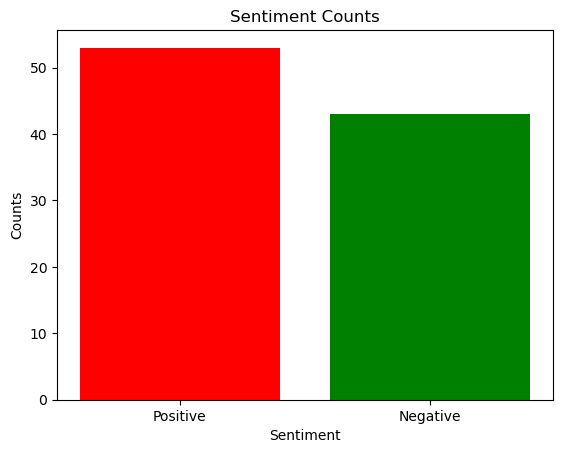

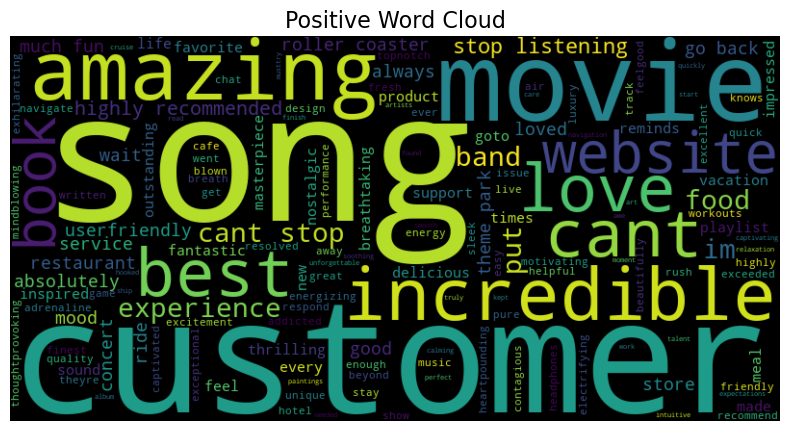

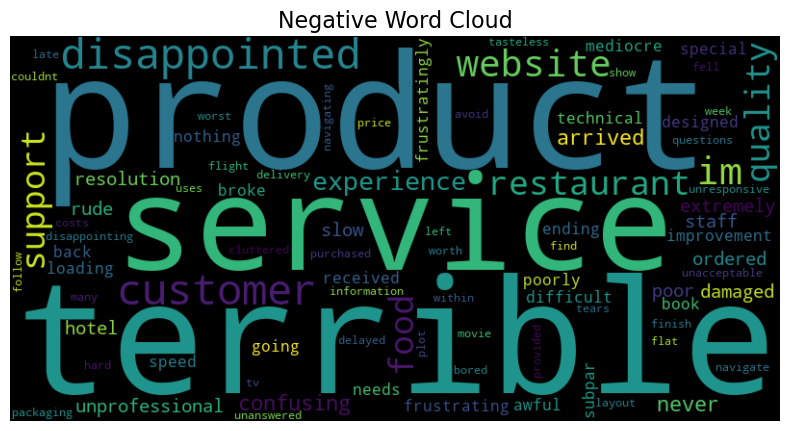

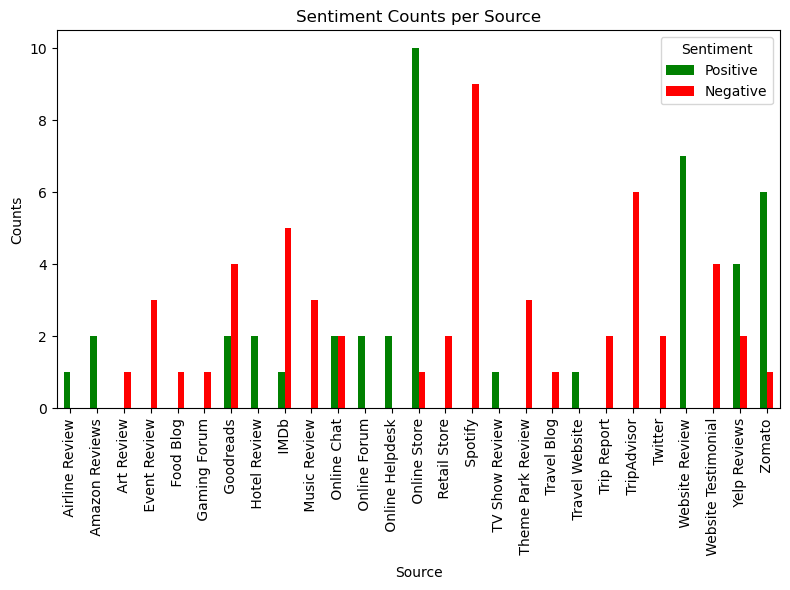

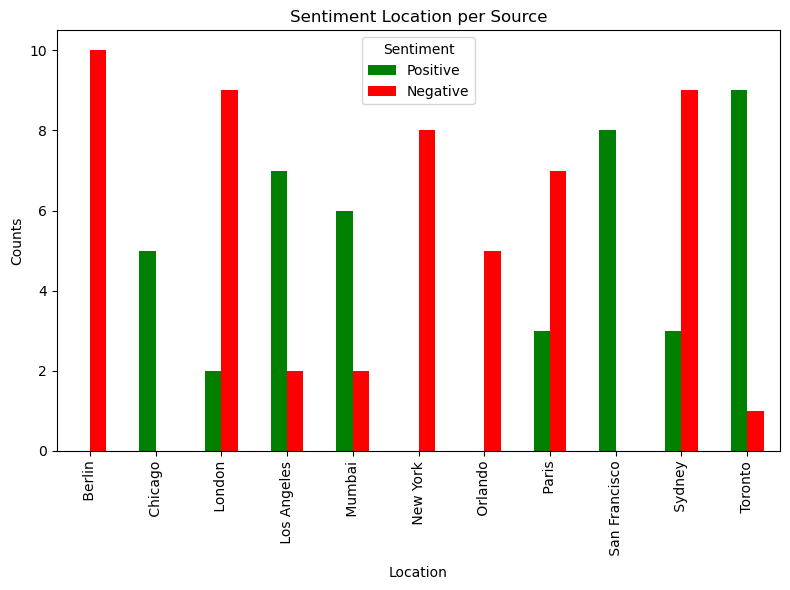

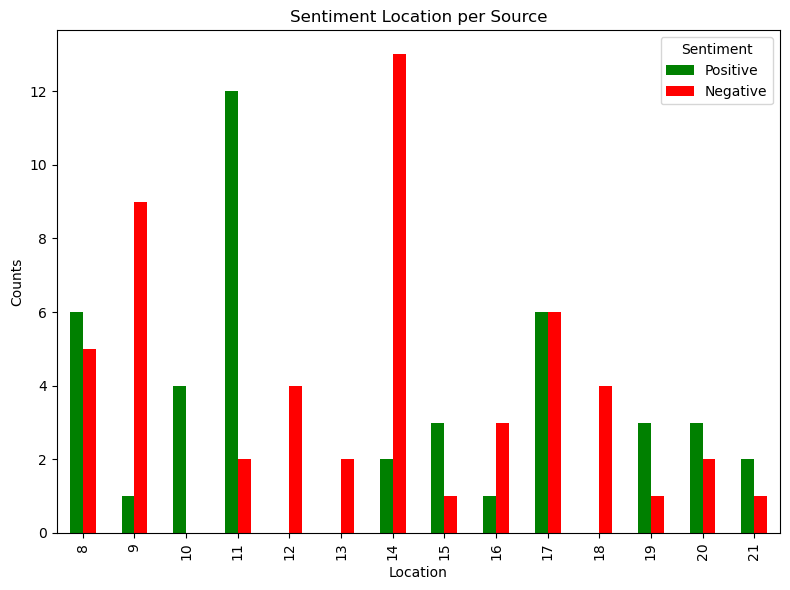

In [4]:
customer_feedback = pd.read_csv("Data/sentiment-analysis.csv")
customer_feedback[['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']] = customer_feedback['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand=True)
customer_feedback = customer_feedback.drop('Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score', axis=1)
customer_feedback.head()

def clean_text(text: pd.Series) -> pd.Series:
    text = text.str.lower()
    text = text.str.replace(r'[^a-z\s]', '', regex=True)
    text = text.str.replace(r'\s+', ' ', regex=True).str.strip()
    return text

customer_feedback['Cleaned_Text'] = clean_text(customer_feedback['Text'])
customer_feedback['Sentiment'] = customer_feedback['Sentiment'].str.strip()
customer_feedback = customer_feedback.dropna()
customer_feedback.head()

sentiment_counts = customer_feedback['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()

positive_text = ' '.join(customer_feedback[customer_feedback['Sentiment'] == 'Positive']['Cleaned_Text'])
negative_text = ' '.join(customer_feedback[customer_feedback['Sentiment'] == 'Negative']['Cleaned_Text'])
stop_words = set(stopwords.words('english'))

def plot_wordcloud(text, title, stopwords):
    if not text.strip():
        print(f"No words to generate a word cloud for: {title}")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords, colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

plot_wordcloud(positive_text, "Positive Word Cloud", stop_words)
plot_wordcloud(negative_text, "Negative Word Cloud", stop_words)

sentiment_counts = customer_feedback.groupby(['Source', 'Sentiment']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))
plt.title('Sentiment Counts per Source')
plt.xlabel('Source')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.tight_layout()
plt.show()

sentiment_counts = customer_feedback.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))
plt.title('Sentiment Location per Source')
plt.xlabel('Location')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.tight_layout()
plt.show()

customer_feedback['Time'] = pd.to_datetime(customer_feedback['Date/Time'])
customer_feedback['Hour'] = customer_feedback['Time'].dt.hour
sentiment_counts = customer_feedback.groupby(['Hour', 'Sentiment']).size().unstack(fill_value=0)
sentiment_counts.plot(kind='bar', stacked=False, color=['green', 'red'], figsize=(8, 6))
plt.title('Sentiment Location per Source')
plt.xlabel('Location')
plt.ylabel('Counts')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.tight_layout()
plt.show()

In [5]:
synonym_dict = {
    'Positive': ['it is good', 'great', 'fantastic', 'awesome', 'love', 'amazing', 'wonderful', 'excellent'],
    'Negative': ['bad', 'horrible', 'terrible', 'awful', 'hate', 'disappointing', 'poor', 'lousy']
}
customer_feedback = customer_feedback[['Sentiment', 'Cleaned_Text']]
df = []
for text in synonym_dict['Positive']:
    df.append([text, 'Positive'])
for text in synonym_dict['Negative']:
    df.append([text, 'Negative'])
df = pd.DataFrame(df, columns=['Cleaned_Text', 'Sentiment'])
customer_feedback = pd.concat([customer_feedback, df], ignore_index=True)

train_texts, test_texts, train_labels, test_labels = train_test_split(customer_feedback['Cleaned_Text'], customer_feedback['Sentiment'], test_size=0.2, random_state=42)
train_labels = train_labels.map({'Negative': 0, 'Positive': 1})
test_labels = test_labels.map({'Negative': 0, 'Positive': 1})

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_inputs = tokenizer(list(train_texts), padding=True, truncation=True, return_tensors="pt", max_length=512)
test_inputs = tokenizer(list(test_texts), padding=True, truncation=True, return_tensors="pt", max_length=512)

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], torch.tensor(train_labels.values, dtype=torch.long))
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], torch.tensor(test_labels.values, dtype=torch.long))

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

C:\Users\manas\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Pleas

In [7]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)
epochs = 6
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_train_loss = float('inf')
counter = 0
patience = 3

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}")

    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping due to no improvement in training loss.")
            break

ERROR! Session/line number was not unique in database. History logging moved to new session 253
Epoch 1/6, Training Loss: 0.6708123584588369
Epoch 2/6, Training Loss: 0.6307827035586039
Epoch 3/6, Training Loss: 0.6148410042126974
Epoch 4/6, Training Loss: 0.5789158840974172
Epoch 5/6, Training Loss: 0.5624642868836721
Epoch 6/6, Training Loss: 0.5540053447087606


In [9]:
model.eval()
total_eval_accuracy = 0
total_eval_loss = 0
predictions, true_labels = [], []

for batch in test_dataloader:
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    logits = outputs.logits
    loss = outputs.loss
    total_eval_loss += loss.item()
    preds = torch.argmax(logits, dim=1).flatten()
    predictions.extend(preds)
    true_labels.extend(labels)

avg_val_loss = total_eval_loss / len(test_dataloader)
print(f"Validation Loss: {avg_val_loss}")
print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

Validation Loss: 0.578504741191864
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.76      0.87        17

    accuracy                           0.83        23
   macro avg       0.80      0.88      0.81        23
weighted avg       0.90      0.83      0.84        23

[[ 6  0]
 [ 4 13]]


In [17]:
# Save the trained BERT model and tokenizer
def save_bert_model(model, tokenizer, output_dir="./sentiment_model2"):
    import os
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print(f"Saving model to {output_dir}...")
    
    # Save the model
    model.save_pretrained(output_dir)
    
    # Save the tokenizer
    tokenizer.save_pretrained(output_dir)
    
    print(f"Model and tokenizer saved successfully to {output_dir}")

# Uncomment and run this line to save your model and tokenizer
save_bert_model(model, tokenizer)

Saving model to ./sentiment_model2...
Model and tokenizer saved successfully to ./sentiment_model2


In [11]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

In [13]:
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Run without opening browser
options.add_argument("--disable-blink-features=AutomationControlled")  # Bypass bot detection

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# amazon_url = "https://www.amazon.in/Daikin-Inverter-Display-Technology-MTKL50U/dp/B0BK1KS6ZD/"
amazon_url="https://www.amazon.in/Daikin-Fixed-Copper-Filter-FTL28U/dp/B09R4SF5SP/"
driver.get(amazon_url)

time.sleep(5)

review_elements = driver.find_elements(By.CLASS_NAME, "a-size-base.review-text")

reviews = [review.text.strip() for review in review_elements if review.text.strip()]

print("\nExtracted Amazon Reviews:")
for i, review in enumerate(reviews[:5], 1):  # first 5 reviews
    print(f"Review {i}: {review}\n\n\n\n")

driver.quit()


Extracted Amazon Reviews:
Review 1: I am trying to summarise this in few points:-

1. This one is my 3rd AC in my apartment, and first from Daikin, that to from online platform (previous ones were from Hitachi). I shall suggest go for an window AC for its sheer longevity and ease of use and service. But if not possible then go for split unit and Daikin is a fair choice.
2. This one is for my one of my kid's room of 105 sqft. The IDU and HDU is very sturdy for its price reference and relatively large in size and can be compared to an 1 ton AC.
3. It's a non inverter AC thus, compressor doesn't work all the time and less fault prone without the PCB and electronics, still very energy efficient. It consumed ~4 units for 11 pm to 6 am operation yesterday. It cools the room within 10 minutes.
4. Their Installation charges are quite steep but Daikin sent me a rate chart in advance. Technician Adil was efficient and humble and done a good job. Unlike other brands In Daikin the power goes to H

In [15]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load sentiment analysis model
# save_path = "./sentiment_model"
# model = BertForSequenceClassification.from_pretrained(save_path)
# tokenizer = BertTokenizer.from_pretrained(save_path)
print("Model Loaded.")
sentiment_labels = {0: "Negative", 1: "Positive"}

def analyze_sentiment(text):
    print("Analyzing reviews.........")
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    return sentiment_labels[predicted_class]

for i, review in enumerate(reviews[:5], 1):
    sentiment = analyze_sentiment(review)
    print(f"Review {i}: {sentiment}")

Model Loaded.
Analyzing reviews.........
Review 1: Positive
Analyzing reviews.........
Review 2: Positive
Analyzing reviews.........
Review 3: Negative
Analyzing reviews.........
Review 4: Positive
Analyzing reviews.........
Review 5: Positive
